# ASUM-DM Methodology Analysis - Case 1: Clustering

## 1. Etapas de entendimiento

### 1.1 Comprensión del negocio
**Objetivo:** Definir el problema, los objetivos de negocio y los requisitos de la solución.

**Problema:** Una empresa de retail busca implementar estrategias de marketing diferenciadas segmentando a sus clientes según su comportamiento.

**Objetivo de Negocio:** Confirmar o rechazar la hipótesis del equipo de mercadeo de que los clientes se pueden dividir en **3 grupos**.

### 1.2 Enfoque analítico
**Tipo de Problema:** Aprendizaje no supervisado (Clustering).

**Método de Construcción:** Se utilizarán y compararán múltiples algoritmos de agrupamiento divididos en 4 secciones:
1.  **Métodos de Partición:** K-Means y K-Medoids.
2.  **Métodos Jerárquicos:** Agglomerative Clustering (Dendrogramas).
3.  **Métodos Basados en Densidad:** DBSCAN (Optimización de Epsilon).
4.  **Métodos Basados en Distribución:** Gaussian Mixture Models (GMM).


## 2. Etapas de preparación

### 2.1 Requisitos de datos
Se requieren datos que describan el perfil demográfico y el comportamiento de compra.

**Diccionario de Datos:**
- `ID`: Identificador del cliente
- `Year_Birth`: Año de nacimiento
- `Education`: Nivel de educación
- `Marital_Status`: Estado civil
- `Income`: Ingresos anuales
- `Kidhome`: Cantidad de niños pequeños
- `Teenhome`: Cantidad de jóvenes
- `Dt_Customer`: Fecha de primera compra
- `Recency`: Días desde la última compra
- `MntWines`: Monto en vinos
- `MntFruits`: Monto en frutas
- `MntMeatProducts`: Monto en carnes
- `MntFishProducts`: Monto en pescados
- `MntSweetProducts`: Monto en dulces
- `MntGoldProds`: Monto en oro
- `NumDealsPurchases`: Compras con descuento
- `NumWebPurchases`: Compras web
- `NumCatalogPurchases`: Compras catálogo
- `NumStorePurchases`: Compras en tienda
- `NumWebVisitsMonth`: Visitas web mensuales
- `AcceptedCmp1-5`: Aceptación de campañas
- `Response`: Aceptación última campaña
- `Complain`: Quejas
- `Z_CostContact`: Costo de contacto
- `Z_Revenue`: Utilidad post-campaña


### 2.2 Recopilación de datos
Los datos se cargan desde `data/datos_caso_1.csv`.


In [23]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb

# Ensure utils can be imported
sys.path.append(os.path.abspath('..'))

from utils.entrega1.data_loader import load_data
from utils.entrega1.eda import get_basic_stats, check_missing_values_viz, plot_distributions_numerical, plot_boxplots, plot_pie_categorical, plot_correlation_matrix
from utils.entrega1.preprocessing import preprocess_pipeline, scale_features
from utils.entrega1.modeling import (run_clustering_models, compare_models, evaluate_clusters_kmeans, 
                                     visualize_clusters_pca, interpret_clusters, run_dbscan, 
                                     plot_dendrogram, plot_knn_distance, optimize_dbscan_grid)
from sklearn.cluster import AgglomerativeClustering, DBSCAN

# Load Data
df = load_data('../data/datos_caso_1.csv')
df.info()

Data loaded successfully with shape: (2240, 29)
<class 'pandas.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   str    
 3   Marital_Status       2240 non-null   str    
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   str    
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  N

### 2.3 Comprensión de datos
Análisis Exploratorio de Datos (EDA).


In [24]:
# Basic Statistics (Transposed)
display(get_basic_stats(df).T)

,count,mean,std,min,25%,50%,75%,max
ID,2240.0,5592.159821,3246.662198,0.0,2828.25,5458.5,8427.75,11191.0
Year_Birth,2240.0,1968.805804,11.984069,1893.0,1959.00,1970.0,1977.00,1996.0
Income,2216.0,52247.251354,25173.076661,1730.0,35303.00,51381.5,68522.00,666666.0
Kidhome,2240.0,0.444196,0.538398,0.0,0.00,0.0,1.00,2.0
Teenhome,2240.0,0.506250,0.544538,0.0,0.00,0.0,1.00,2.0
Recency,2240.0,49.109375,28.962453,0.0,24.00,49.0,74.00,99.0
MntWines,2240.0,303.935714,336.597393,0.0,23.75,173.5,504.25,1493.0
MntFruits,2240.0,26.302232,39.773434,0.0,1.00,8.0,33.00,199.0
MntMeatProducts,2240.0,166.950000,225.715373,0.0,16.00,67.0,232.00,1725.0
MntFishProducts,2240.0,37.525446,54.628979,0.0,3.00,12.0,50.00,259.0


<Figure size 1000x600 with 0 Axes>

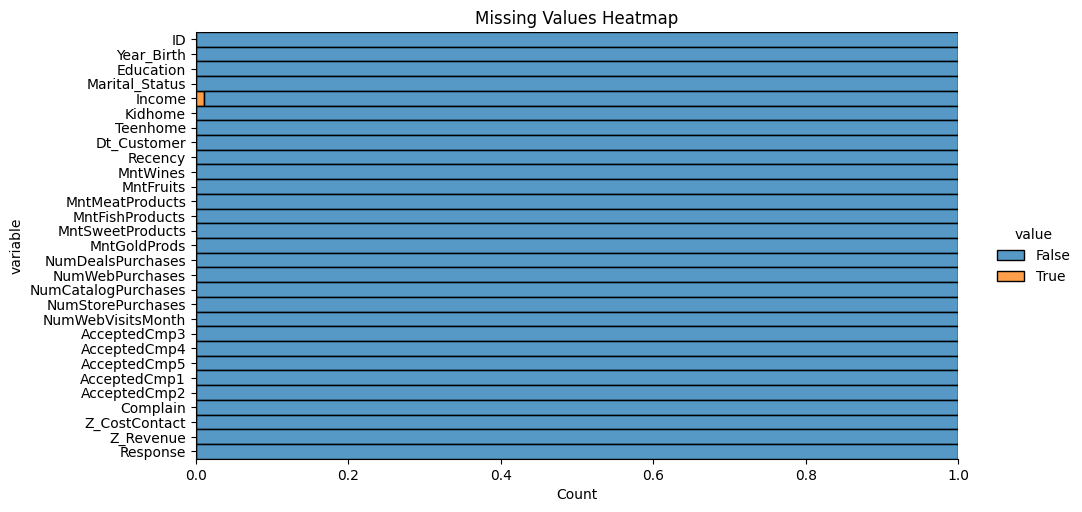

In [25]:
# Missing Values Visualization
check_missing_values_viz(df)

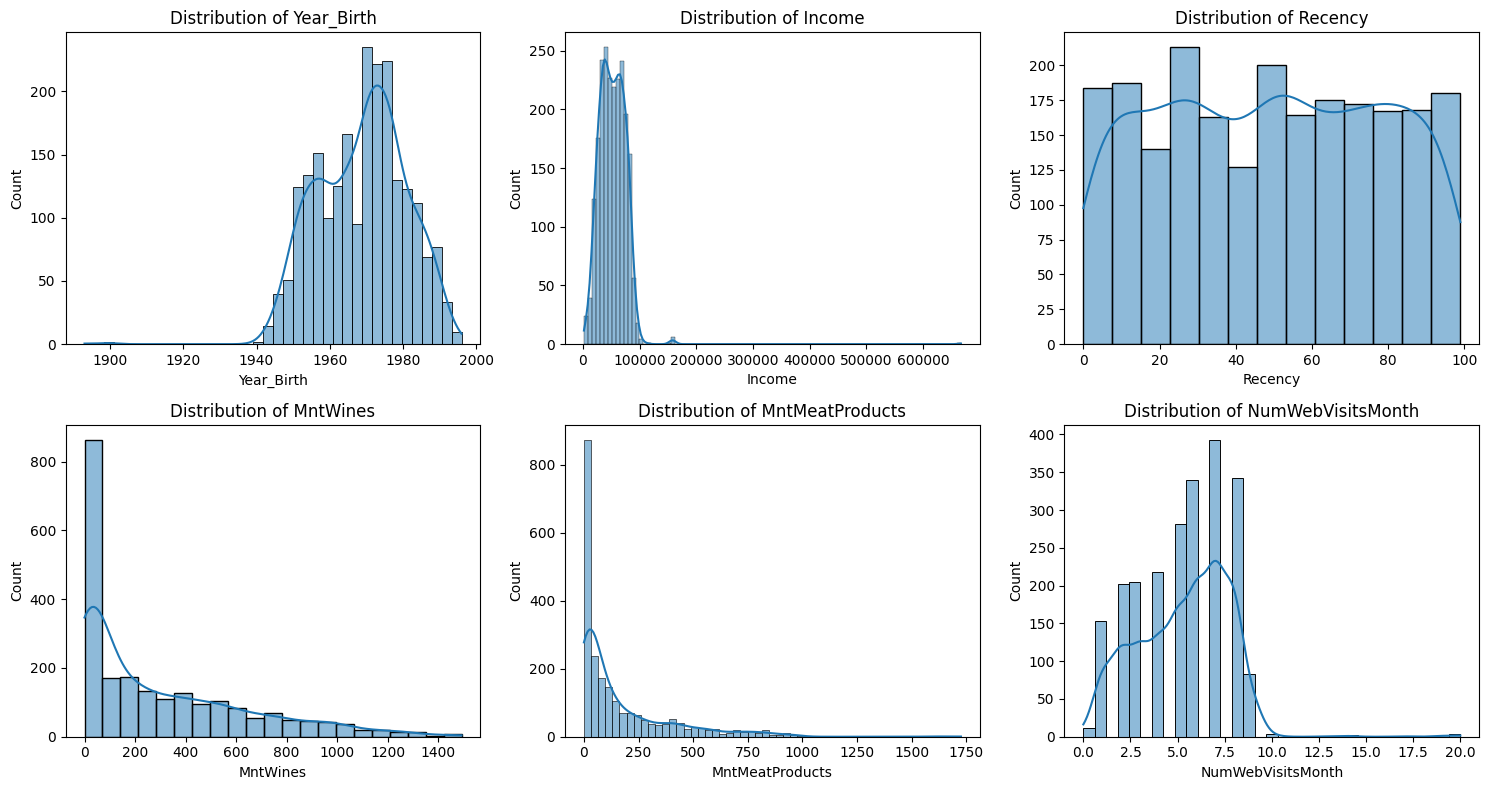

In [26]:
# Numerical Distributions
numerical_cols = ['Year_Birth', 'Income', 'Recency', 'MntWines', 'MntMeatProducts', 'NumWebVisitsMonth']
plot_distributions_numerical(df, numerical_cols)

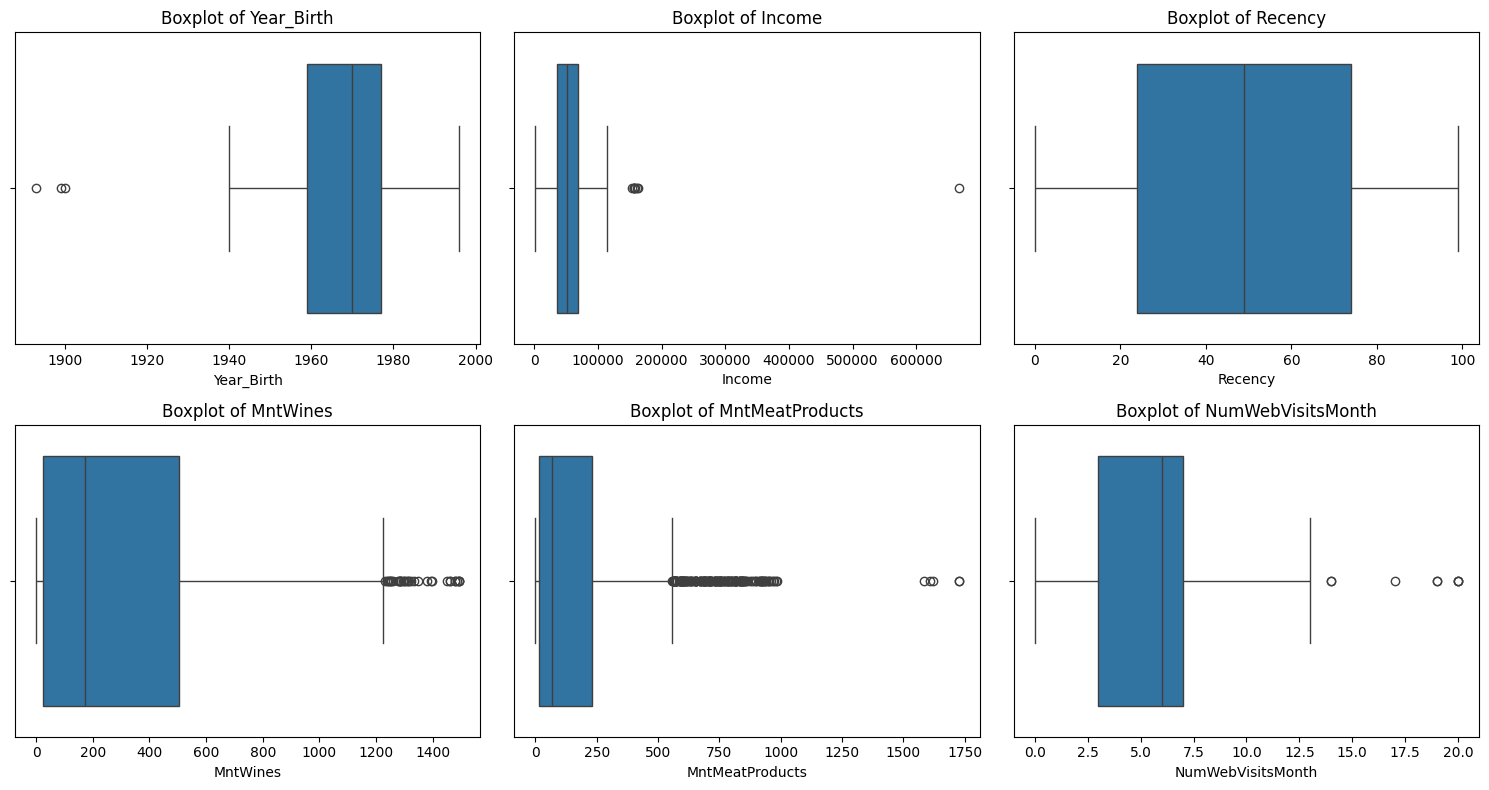

In [27]:
# Boxplots for Outliers
plot_boxplots(df, numerical_cols)

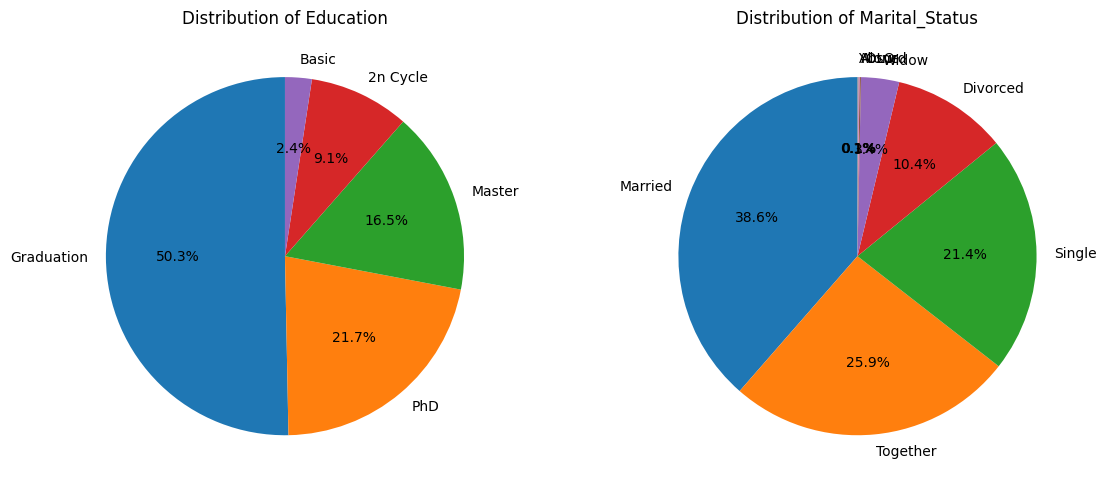

In [28]:
# Categorical Distributions (Pie Charts)
categorical_cols = ['Education', 'Marital_Status']
plot_pie_categorical(df, categorical_cols)

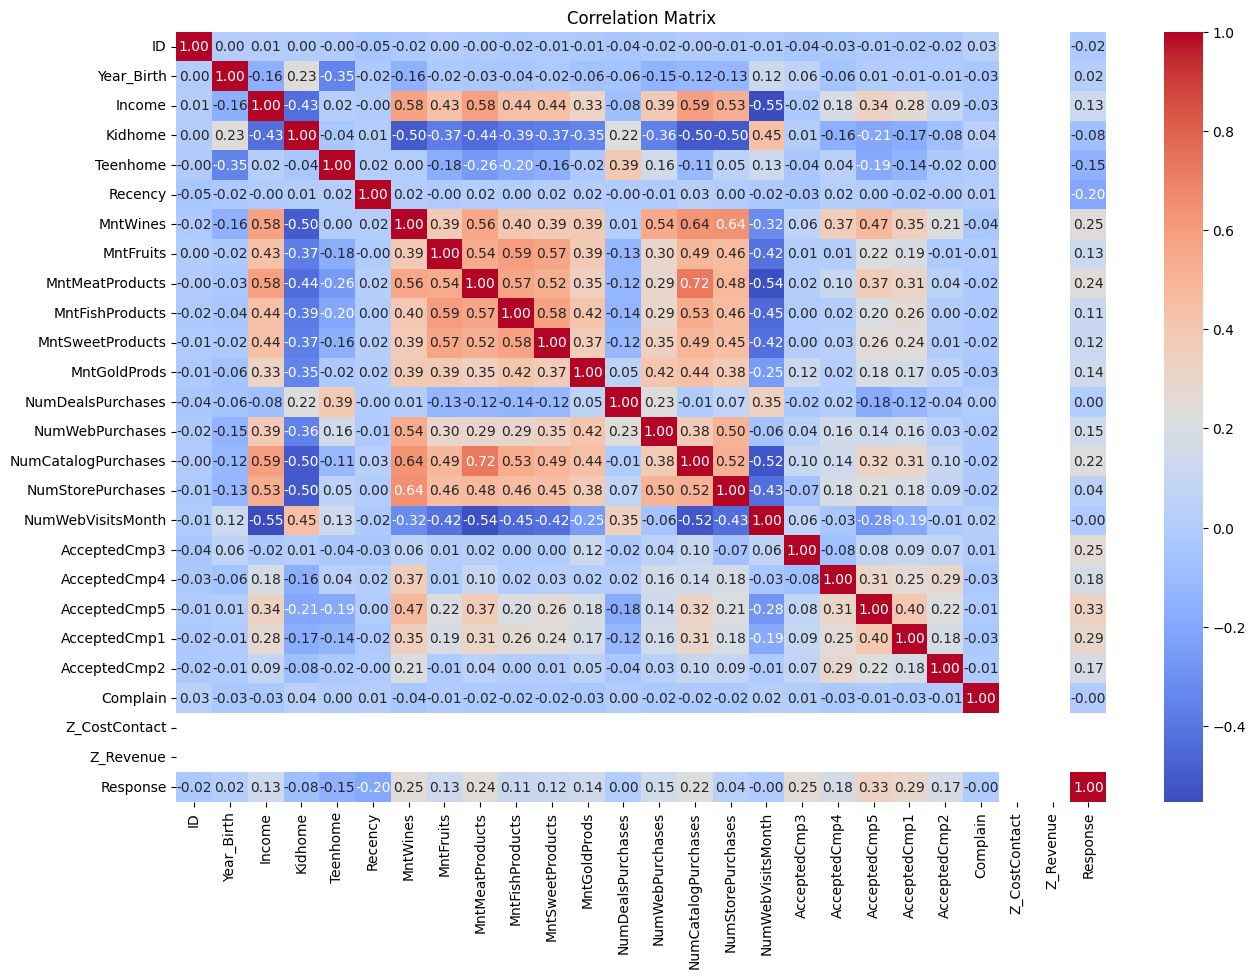

In [29]:
# Correlation Matrix
plot_correlation_matrix(df)

## 3. Etapas de ejecución

### 3.1 Preparación de los datos

Esta preparacion de los datos incluye 

La creacion de 5 nuevas columnas:
* Days_Being_Customer: Conversion de `Dt_Customer` a ser un numero de dias.
* Total_Spent: La suma de las columnas que indican el gasto por categoria de cada cliente.
* Total_Purchases: La suma de las columnas que indican la cantidad de compras por categoria de cada cliente.
* Total_Offers_Accepted: La suma de todas las ofertas aceptadas que ha tenido un cliente.
* Age: Conversion de `Year_Birth` a ser la edad en años del cliente.

Transformar datos atipicos:
* Convertir las personas que tienen estatus marital `Alone` a ser `Single`

Remover datos atipicos:
* Personas nacidas antes que `1900`
* La persona que tiene ingresos de mas de `150000`
* Personas que compran mas de `1250` productos carnicos
* Las personas que visitan mas de `15` veces la pagina web por mes
* Personas con status marital `Absurd` o `YOLO`

Borrar los datos nulos:
* 24 entradas de la columna `Income`


Convertir datos categoricos en numericos por medio del uso de `pd.get_dummies()`

In [30]:
# Preprocessing Pipeline
df_prep = preprocess_pipeline(df)

# Select features for clustering
features_to_cluster = ['Age', 'Income', 'Kidhome', 'Teenhome', 'Recency', 
                       'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 
                       'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 
                       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 
                       'NumWebVisitsMonth', 'Tenure_Days', 'Total_Mnt', 'Total_Num_Purchases', 
                       'Family_Size', 'Days_Being_Customer', 'Total_Offers_Accepted']

features_to_cluster = [c for c in features_to_cluster if c in df_prep.columns]

# Scale Features
df_scaled, scaler = scale_features(df_prep, features_to_cluster)


### 3.2 Modelado Detallado
Evaluación profunda de 4 tipos de algoritmos.


#### 3.2.1 Métodos de Partición (K-Means)
Evaluación del número óptimo de clusters usando el método del codo y silueta.


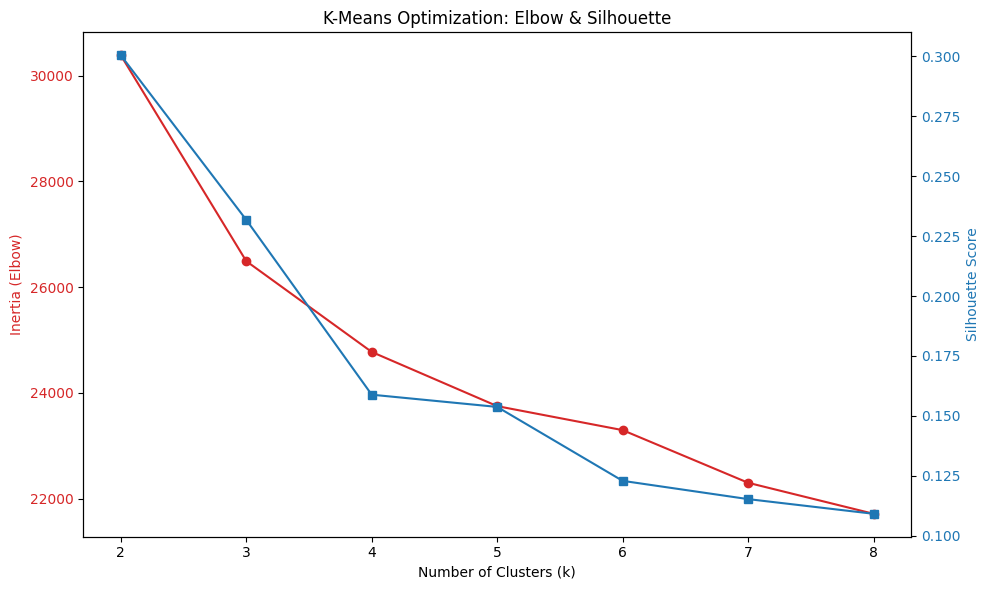

In [31]:
# K-Means Deep Dive
evaluate_clusters_kmeans(df_scaled, range(2, 9))

#### 3.2.2 Métodos Jerárquicos Aglomerativos
Análisis mediante Dendrogramas para visualizar la estructura de agrupamiento.


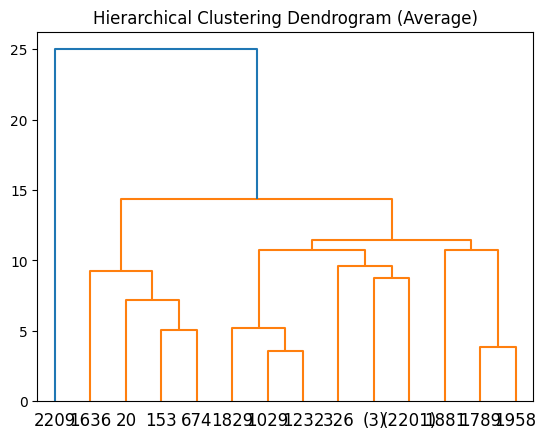

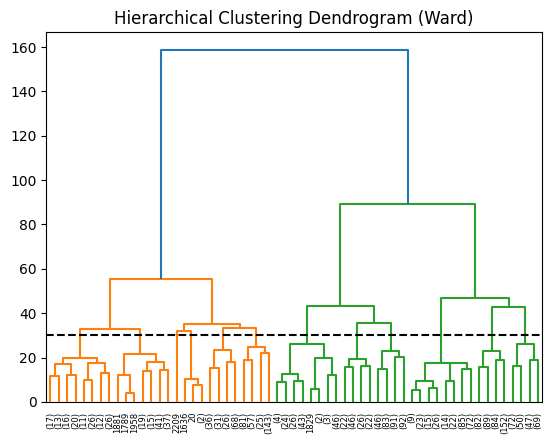

In [32]:
# Average Linkage Dendrogram
plt.title('Hierarchical Clustering Dendrogram (Average)')
model_avg = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='average')
model_avg = model_avg.fit(df_scaled)
plot_dendrogram(model_avg, truncate_mode='level', p=5)
plt.show()

# Ward Linkage Dendrogram
plt.title('Hierarchical Clustering Dendrogram (Ward)')
model_ward = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='ward')
model_ward = model_ward.fit(df_scaled)
plot_dendrogram(model_ward, truncate_mode='level', p=5)
plt.axhline(y=30, linestyle='dashed', color='black') # Example cut
plt.show()

#### 3.2.3 Métodos Basados en Densidad (DBSCAN)
Identificación de clusters densos y ruido. Estimación de `epsilon` usando KNN y optimización de silueta.


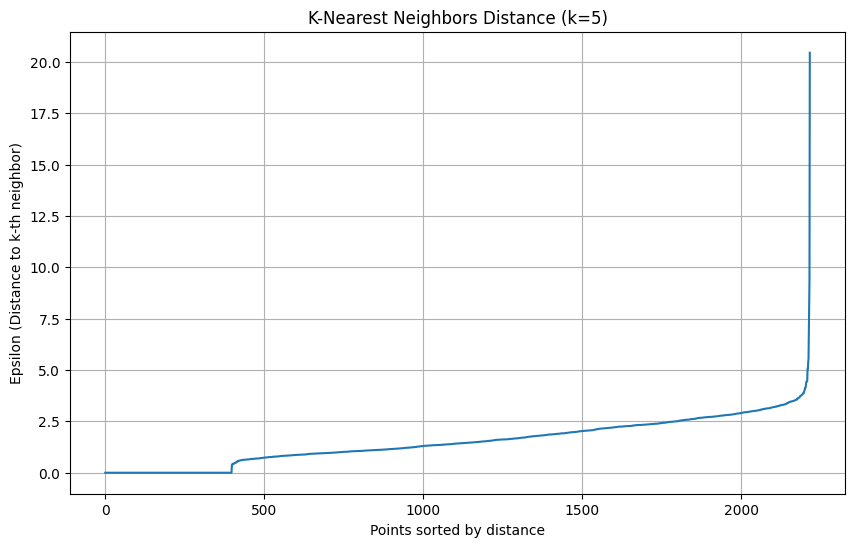

In [33]:
# KNN Distance Plot to estimate Epsilon
plot_knn_distance(df_scaled, k=5)

Optimizing DBSCAN...


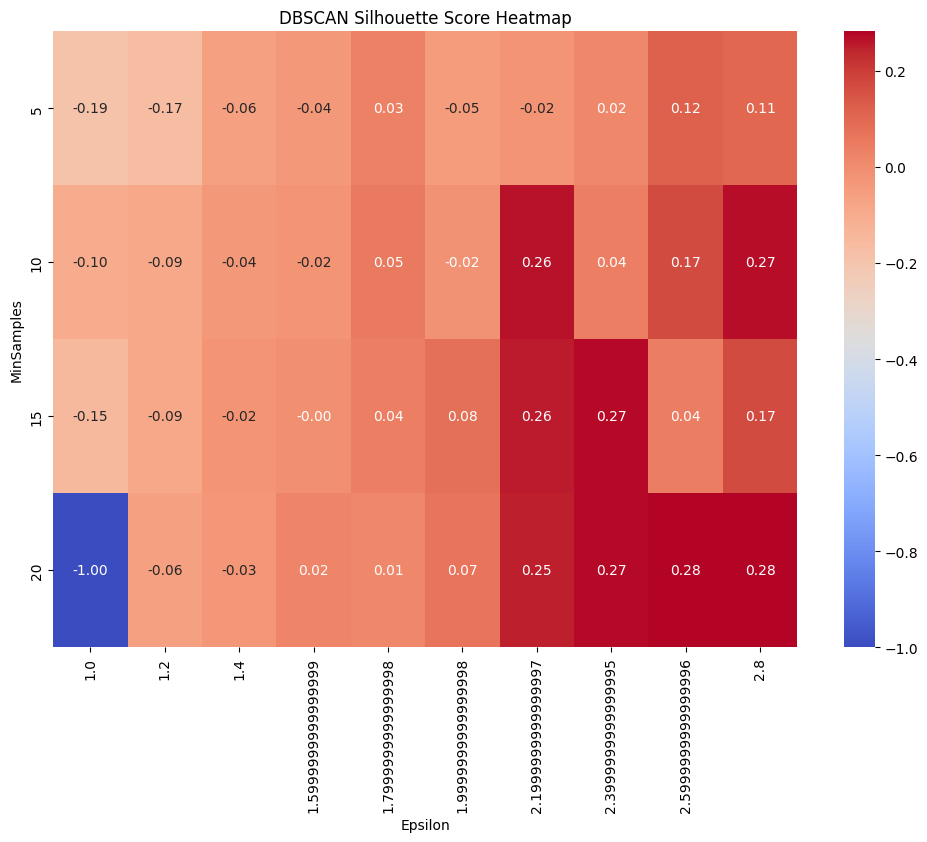

In [34]:
# DBSCAN Grid Search for Optimal Hyperparameters
eps_range = np.arange(1.0, 3.0, 0.2)
min_samples_range = range(5, 25, 5)
print("Optimizing DBSCAN...")
dbscan_results = optimize_dbscan_grid(df_scaled, eps_range, min_samples_range)

#### 3.2.4 Métodos Basados en Modelos (GMM)
(Incluido en la comparación final)


### 3.3 Comparación Total de Modelos
Se comparan las métricas de Silueta y Davies-Bouldin de los mejores modelos encontrados.


Best DBSCAN params: Eps=2.5999999999999996, MinSamples=20.0


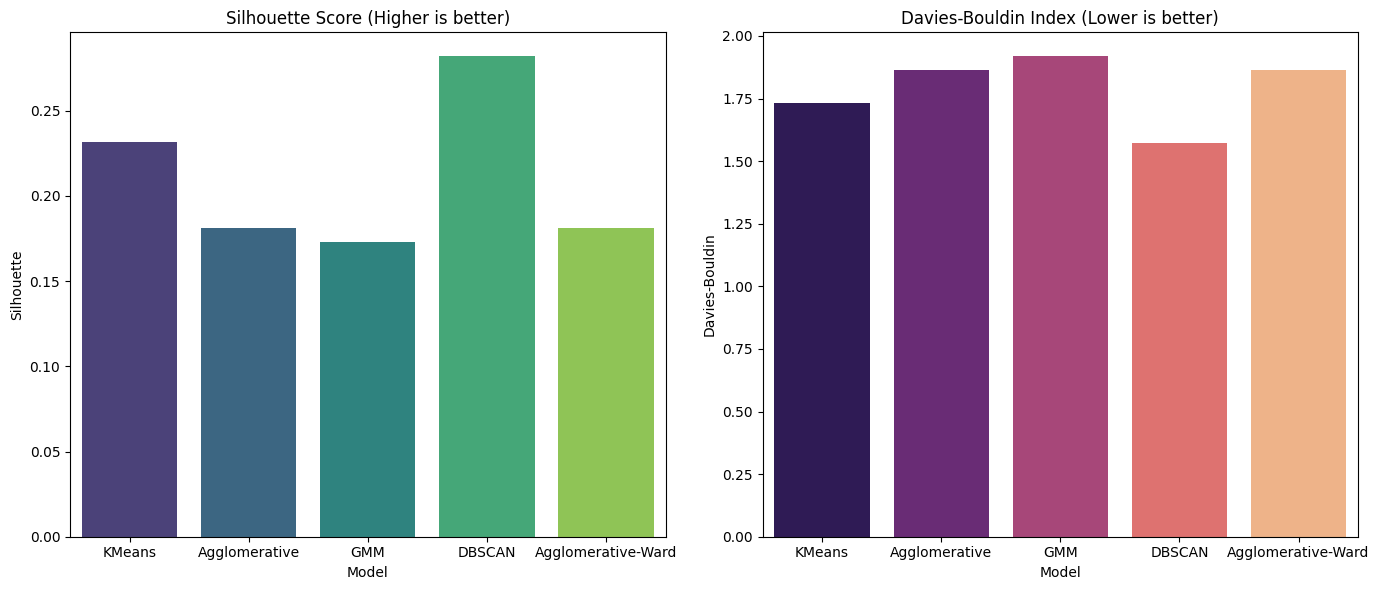

,Model,Silhouette,Davies-Bouldin
0,KMeans,0.231803,1.730438
1,Agglomerative,0.181325,1.865431
2,GMM,0.172930,1.918598
3,DBSCAN,0.281938,1.572152
4,Agglomerative-Ward,0.181325,1.865431


In [35]:
# Collect all results
results = run_clustering_models(df_scaled, n_clusters=3)

# Add optimized DBSCAN (Example based on heatmaps likely best)
# Assuming eps=1.8 works well from inspection, or pick best from dbscan_results
best_dbscan_row = dbscan_results.loc[dbscan_results['Score'].idxmax()]
print(f"Best DBSCAN params: Eps={best_dbscan_row['Epsilon']}, MinSamples={best_dbscan_row['MinSamples']}")

results['DBSCAN'] = run_dbscan(df_scaled, eps=best_dbscan_row['Epsilon'], min_samples=int(best_dbscan_row['MinSamples']))

# Review Agglomerative with Ward (k=3)
agg_ward = AgglomerativeClustering(n_clusters=3, linkage='ward')
results['Agglomerative-Ward'] = agg_ward.fit_predict(df_scaled)

# Compare
metrics_final = compare_models(df_scaled, results)
display(metrics_final)

### 3.4 Evaluación Final e Interpretación
Se seleccionan los clusters de **K-Means (k=3)** (o el mejor modelo) para confirmar la hipótesis y perfilar los grupos.


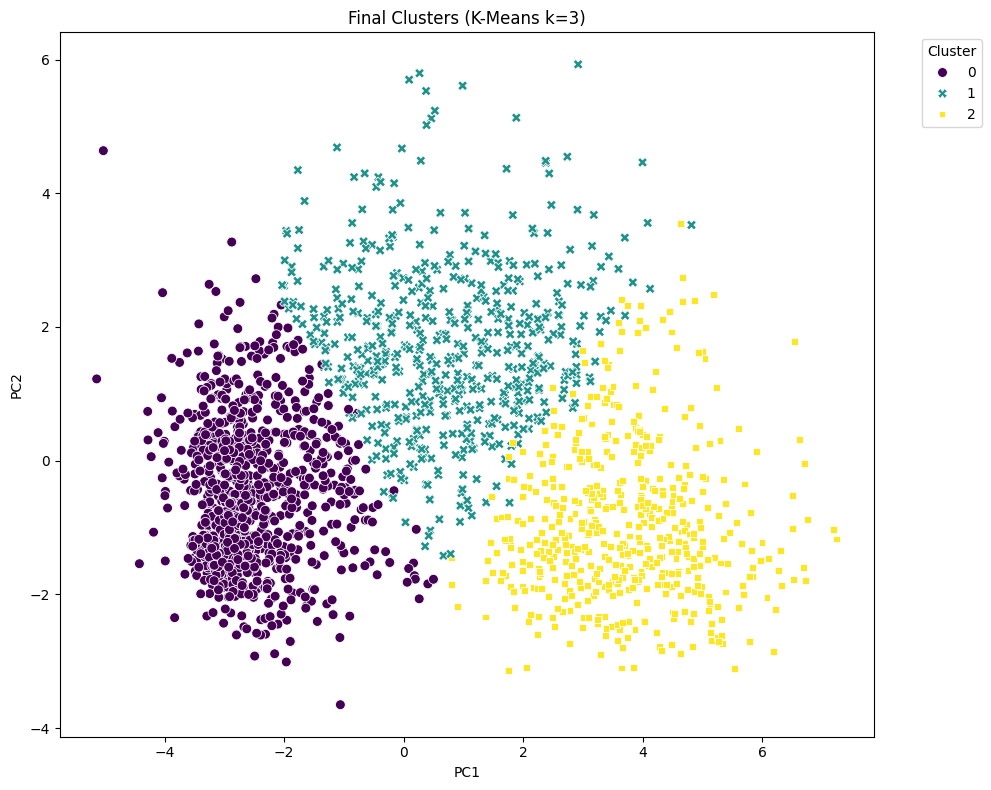

Perfilamiento de los 3 grupos:


Cluster,0,1,2
Age,54.447600,61.158756,57.792808
Income,34942.786484,57742.384615,76751.244863
Kidhome,0.778648,0.263502,0.039384
Teenhome,0.444662,0.934534,0.162671
Recency,49.343781,47.921440,49.575342
MntWines,40.827620,453.076923,612.273973
MntFruits,4.965720,21.446809,68.888699
MntMeatProducts,22.544564,135.310966,452.688356
MntFishProducts,7.001959,29.080196,100.150685
MntSweetProducts,5.055828,22.423895,70.261986


In [36]:
# Visualize
visualize_clusters_pca(df_scaled, results['KMeans'], title='Final Clusters (K-Means k=3)')

# Interpretation
print("Perfilamiento de los 3 grupos:")
display(interpret_clusters(df_prep, results['KMeans'])[features_to_cluster].T)

## 4. Conclusiones
- **Validación de Hipótesis:** [Completar tras análisis: ¿Se sostienen los 3 grupos?]
- **Mejor Modelo:** [Completar tras ver gráfica de barras]
- **Caracterización:**
    - **Cluster 0:** ...
    - **Cluster 1:** ...
    - **Cluster 2:** ...
